In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

#from tabulate import tabulate
#from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [41]:
device = torch.device('cpu')

In [18]:
from transformers import BertTokenizer, BertForSequenceClassification

In [104]:
#세가지 모델 불러오기
model_f = BertForSequenceClassification.from_pretrained("model/food/pytorch_model.bin", config = 'model/food/config.json').to(device)

model_s=BertForSequenceClassification.from_pretrained("model/service/pytorch_model.bin", config = 'model/service/config.json').to(device)

model_p=BertForSequenceClassification.from_pretrained("model/price/pytorch_model.bin", config = 'model/price/config.json').to(device)

In [105]:
model_f.eval()
model_s.eval()
model_p.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [44]:
print(device)
#model_f = model_f.to(device)

cpu


In [35]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [36]:
MAX_LENGTH=150
food_token_id = []
food_attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


# 리스트를 텐서로
#food_token_id = torch.cat(food_token_id, dim = 0)
#food_attention_masks = torch.cat(food_attention_masks, dim = 0)
#labels = torch.tensor(labels)

In [106]:
def test_sentence_food(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model_f(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction

def test_sentence_service(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model_s(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction

def test_sentence_price(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model_p(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction

In [107]:
def classifyReviews_food(textarr):
    i=0
    
    posResult=[] # [[String text,Boolean prediction ], ... ]
    negResult=[] # [[String text,Boolean prediction ], ... ]

    neg=0
    pos=0

    for text in textarr:
        prediction=test_sentence_food(text)
        if(prediction=="Negative"):
            neg+=1
            negResult.append([text,0])
        else:
            pos+=1
            posResult.append([text,1])

        print("=============================== Input {} ===============================".format(i+1))
        print(text)
        print("model result:",prediction)
        print("")
        i+=1


    print("Positive ratio: {:.4f}".format(pos/len(textarr)))
    print("Negative ratio: {:.4f}".format(neg/len(textarr)))
    return posResult, negResult

def classifyReviews_service(textarr):
    i=0
    
    posResult=[] # [[String text,Boolean prediction ], ... ]
    negResult=[] # [[String text,Boolean prediction ], ... ]

    neg=0
    pos=0

    for text in textarr:
        prediction=test_sentence_service(text)
        if(prediction=="Negative"):
            neg+=1
            negResult.append([text,0])
        else:
            pos+=1
            posResult.append([text,1])

        print("=============================== Input {} ===============================".format(i+1))
        print(text)
        print("model result:",prediction)
        print("")
        i+=1


    print("Positive ratio: {:.4f}".format(pos/len(textarr)))
    print("Negative ratio: {:.4f}".format(neg/len(textarr)))
    return posResult, negResult

def classifyReviews_price(textarr):
    i=0
    
    posResult=[] # [[String text,Boolean prediction ], ... ]
    negResult=[] # [[String text,Boolean prediction ], ... ]

    neg=0
    pos=0

    for text in textarr:
        prediction=test_sentence_price(text)
        if(prediction=="Negative"):
            neg+=1
            negResult.append([text,0])
        else:
            pos+=1
            posResult.append([text,1])

        print("=============================== Input {} ===============================".format(i+1))
        print(text)
        print("model result:",prediction)
        print("")
        i+=1


    print("Positive ratio: {:.4f}".format(pos/len(textarr)))
    print("Negative ratio: {:.4f}".format(neg/len(textarr)))
    return posResult, negResult

In [102]:
def draw_bar_charts(ratio1, ratio2, ratio3):
    labels = ['Positive', 'Negative']
    ratios = [[ratio1[0], ratio1[1]], [ratio2[0], ratio2[1]], [ratio3[0], ratio3[1]]]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4)) 
    catList=['Food','Service','Price']
    
    for i, ax in enumerate(axs):
        ax.bar(labels, ratios[i])
        ax.set_xlabel('Ratios')
        ax.set_ylabel('Values')
        ax.set_title('{}'.format(catList[i]))
        ax.set_ylim(0, 1.0)
        
        for j, ratio in enumerate(ratios[i]):
            label = f'{ratio:.4f}'
            ax.text(j, ratio, label, ha='center', va='bottom', fontsize=12)
        
    

    plt.tight_layout() 
    plt.show()

In [20]:
def printLenStat(df,colName):
    lendf = pd.DataFrame()
    lendf['length'] = df[colName].apply(len)
    print(lendf.length.describe())

In [85]:
#naver 실시간 시연

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/sootawon_food.csv'
df_food = pd.read_csv(test_url,sep=',', header=0)
df_food.head(5)

test_url='./data/naver_data/sootawon_service.csv'
df_service = pd.read_csv(test_url,sep=',', header=0)
df_service.head(5)

test_url='./data/naver_data/sootawon_price.csv'
df_price = pd.read_csv(test_url,sep=',', header=0)
df_price.head(5)

,id,category,text,trans_text
0,425,price,탕수육 소 가격대비 양이 너무 적어요 ㅠㅠ\n갈비짬뽕 리뷰 보고 기대하고가는데 \n...,It's too small for the price of the tangsuyuk ...
1,426,price,맛있는데 가격은 좀 있어요,"It's good, but it's a bit expensive"
2,427,price,군만두랑 옛날볶음밥 맛있어요~ 갈비짬뽕은 맛이 없는건 아닌데 가격대비 평범한 맛이에...,Fried dumplings and old fried rice are good Ga...
3,428,price,가격이 저렴한건 아니지만 진짜 맛있어요,"It's not cheap, but it's really good"
4,429,price,짬뽕은 야채와 해물 불맛 좋고 짜장면은 순한맛입니다 탕수육은 가격대비 양이 적어요 ...,"Spicy seafood and vegetables are good, and bla..."


In [88]:
print("=========== food ===========")
printLenStat(df_food,'trans_text')
print()
print("=========== service ===========")
printLenStat(df_service,'trans_text')
print()
print("=========== price ===========")
printLenStat(df_price,'trans_text')


=========== food ===========
count    385.000000
mean      80.719481
std       98.937871
min        9.000000
25%       20.000000
50%       43.000000
75%      103.000000
max      840.000000
Name: length, dtype: float64

=========== service ===========
count     40.000000
mean     176.450000
std      167.616618
min       12.000000
25%       54.750000
50%      121.000000
75%      253.000000
max      840.000000
Name: length, dtype: float64

=========== price ===========
count     10.000000
mean     128.600000
std      106.405096
min       35.000000
25%       52.750000
50%       99.500000
75%      167.750000
max      389.000000
Name: length, dtype: float64


In [84]:
food_text=df_food.trans_text.values
food_posResult,food_negResult=classifyReviews_food(food_text)
foodR=[0]*2
foodR[0]=len(food_posResult)/(len(food_posResult)+len(food_negResult))
foodR[1]=len(food_negResult)/(len(food_posResult)+len(food_negResult))

=============================== Input 1 ===============================
Black Bean Noodles taste normal but have a lot. Sirloin tangsuyuk is delicious without the smell of meat.. We don't have enough sauce for jajangmyeon, but they give us more if you request.. And I think galbi jjamppong has two large ribs, so I think it's cost-effective!
model result: Positive

=============================== Input 2 ===============================
If you take a bite of fried dumplings, you can feel the juiciness. It's seasoned enough, so you don't have to dip it in soy sauce. Octopus jjamppong's octopus is very chewy.. The parking lot attached to the building is too small, so you have to use the parking lot that is a little far away.
model result: Positive

=============================== Input 3 ===============================
It's a basic jjamppong, but it's a lot, so you can eat it full every time you go!!Octopus jjamppong is really delicious because it's full of octopus and chewy I'll eat it aga

=============================== Input 34 ===============================
It's good
model result: Positive

=============================== Input 35 ===============================
Jjamppong Sweet and Sour Pork Restaurant :)
model result: Negative

=============================== Input 36 ===============================
I looked for jajangmyeon because I thought of it, but it's delicious. The service is good and kind, and I'm eating well. Thank you.
model result: Positive

=============================== Input 37 ===============================
Jajangmyeon and jjamppong are good
model result: Positive

=============================== Input 38 ===============================
It's delicious. Jjambbo
model result: Positive

=============================== Input 39 ===============================
It was hard to find a good place for jjamppong, but this place is rich in seafood and the soup tastes clean. Please try it^^
model result: Positive

=============================== Input 40 =======

=============================== Input 82 ===============================
It's so good!
model result: Positive

=============================== Input 83 ===============================
It's been a while. Tangsuyuk is good
model result: Positive

=============================== Input 84 ===============================
Sweet and sour pork is so good
model result: Positive

=============================== Input 85 ===============================
It doesn't taste strong, but it's light and delicious. moderate amount of food
model result: Positive

=============================== Input 86 ===============================
It's a famous Chinese restaurant in the neighborhood. There were especially many fruit flies on the day I visited.
model result: Positive

=============================== Input 87 ===============================
It's deliciousLol. I wish you a prosperity in your favorite handmade garden
model result: Positive

=============================== Input 88 =========================

=============================== Input 136 ===============================
I acknowledge the jjamppong restaurant!! Chewy hand-made noodles with soup that makes you feel comfortable!!  I recommend black bean noodles. So-so
model result: Positive

=============================== Input 137 ===============================
I searched this place on the internet and found it. Galbi Jjamppong is really good. I don't recommend oyster jjamppong, but I strongly recommend galbi jjamppong
model result: Positive

=============================== Input 138 ===============================
It's so different from 2 years ago and now I was eating beef ribs jjamppong, but it was cold, and it was not delicious compared to the price, and I almost broke my teeth because I was hungry, but I can't say that I ate it well. Ribs smell like pork and they just sell it with regular jjamppong. Jajangmyeon has the same taste except for handmade noodles The store doesn't heat up either, so the employees wear it in layer

=============================== Input 184 ===============================
I visited again after a month and ate. As expected, you ate deliciously. ?
model result: Positive

=============================== Input 185 ===============================
It's good
model result: Positive

=============================== Input 186 ===============================
Jajangmyeon and jjamppong are so good. Sweet and sour pork is so crispy and delicious I can chew the meat well, too! Sweet and sour pork is the best
model result: Positive

=============================== Input 187 ===============================
It's good
model result: Positive

=============================== Input 188 ===============================
It's a place that I often go to local restaurants. We were going together, but I got confused with Tangsuyuk, so I ordered a medium-sized one and ate it in a large one
model result: Positive

=============================== Input 189 ===============================
It's good
model result: 

=============================== Input 226 ===============================
It's good!
model result: Positive

=============================== Input 227 ===============================
It was delicious
model result: Positive

=============================== Input 228 ===============================
A delicious restaurant on video call
model result: Positive

=============================== Input 229 ===============================
Jjamppong and sweet and sour pork are all good
model result: Positive

=============================== Input 230 ===============================
Tangsuyuk and jjamppong are really plentiful and delicious^^
model result: Positive

=============================== Input 231 ===============================
It was delicious
model result: Positive

=============================== Input 232 ===============================
Jjamppong restaurant
model result: Positive

=============================== Input 233 ===============================
Wow this is my first time eat

=============================== Input 274 ===============================
It's good
model result: Positive

=============================== Input 275 ===============================
As expected, it's like a good restaurant
model result: Positive

=============================== Input 276 ===============================
It's my first time going there and Mapa Tofu is good
model result: Positive

=============================== Input 277 ===============================
It tastes like jjamppong.
model result: Positive

=============================== Input 278 ===============================
It's not greasy and it's awkward, so you don't get tired of it It's a new world of Chinese food
model result: Negative

=============================== Input 279 ===============================
Your hands taste really good. I'll visit you often^^
model result: Positive

=============================== Input 280 ===============================
The soup is clean and delicious~~
model result: Positive

=

=============================== Input 331 ===============================
It's not like beef ribs jjamppong is so good. I thought my stomach was going to explode. I inhaled it because it was so good^^
model result: Negative

=============================== Input 332 ===============================
It's so delicious
model result: Positive

=============================== Input 333 ===============================
It's clean and delicious
model result: Positive

=============================== Input 334 ===============================
It's goodLol
model result: Positive

=============================== Input 335 ===============================
I think everyone will enjoy it
model result: Positive

=============================== Input 336 ===============================
As expected, it's delicious
model result: Positive

=============================== Input 337 ===============================
It's good. I hope it's spicy
model result: Positive

=============================== Input 338 =

=============================== Input 385 ===============================
Noodles and jjajang and jjamppong are really good! But it's a shame that the parking lot is small. There's a baby chair, too! The price is a bit high
model result: Positive

Positive ratio: 0.8987
Negative ratio: 0.1013


In [91]:
service_text=df_service.trans_text.values
service_posResult,service_negResult=classifyReviews_service(service_text)
serviceR=[0]*2
serviceR[0]=len(service_posResult)/(len(service_posResult)+len(service_negResult))
serviceR[1]=len(service_negResult)/(len(service_posResult)+len(service_negResult))

=============================== Input 1 ===============================
It's a basic jjamppong, but it's a lot, so you can eat it full every time you go!!Octopus jjamppong is really delicious because it's full of octopus and chewy I'll eat it again next time. . The staff were kind and delicious, so I had a great meal??
model result: Positive

=============================== Input 2 ===============================
Galbi jjamppong is the signature dish, so I ordered it It's my first time eating galbi jjamppong, but it was really delicious because the soup was thick?? I left it because the ribs were big and the amount was too much The tangsuyuk was chewy and the batter wasn't thick, so I ate it deliciously The boss is very kind, too It's definitely recommended to revisit!
model result: Negative

=============================== Input 3 ===============================
the unkindness of the staff
model result: Negative

=============================== Input 4 ===============================


=============================== Input 31 ===============================
Staff members are so kind~~ It's delicious, so I think I'll come often!
model result: Positive

=============================== Input 32 ===============================
The service is really good^^
model result: Positive

=============================== Input 33 ===============================
Clean and kind The soup is good and the tangsuyuk is crispy and delicious I'll go again next time
model result: Positive

=============================== Input 34 ===============================
It's delicious and kind The serving robot is cute, too?
model result: Positive

=============================== Input 35 ===============================
It was the best Chinese food I had recently! He's kind and has clean hygiene. It's the best!
model result: Positive

=============================== Input 36 ===============================
Galbi jjamppong and tangsuyuk food are delicious!! The jjamppong was not spicy at all, so even

In [108]:
price_text=df_price.trans_text.values
price_posResult,price_negResult=classifyReviews_price(price_text)
priceR=[0]*2
priceR[0]=len(price_posResult)/(len(price_posResult)+len(price_negResult))
priceR[1]=len(price_negResult)/(len(price_posResult)+len(price_negResult))

=============================== Input 1 ===============================
It's too small for the price of the tangsuyuk filling ㅠㅠ?????. I'm looking forward to the review of Galbi Jjamppong. I don't like the taste because it's too small. Tray jajangmyeon. Compared to the price of tray jajangmyeon in other places, there's not much seafood It's good to eat Chapagetti. I'm disappointed when I read the reviews And the parking manager is completely out of manners.
model result: Negative

=============================== Input 2 ===============================
It's good, but it's a bit expensive
model result: Negative

=============================== Input 3 ===============================
Fried dumplings and old fried rice are good Galbi jjamppong is not bad, but it tastes normal for its price..It's perfect to eat it with rice because the noodles are not good.
model result: Positive

=============================== Input 4 ===============================
It's not cheap, but it's really good
mo

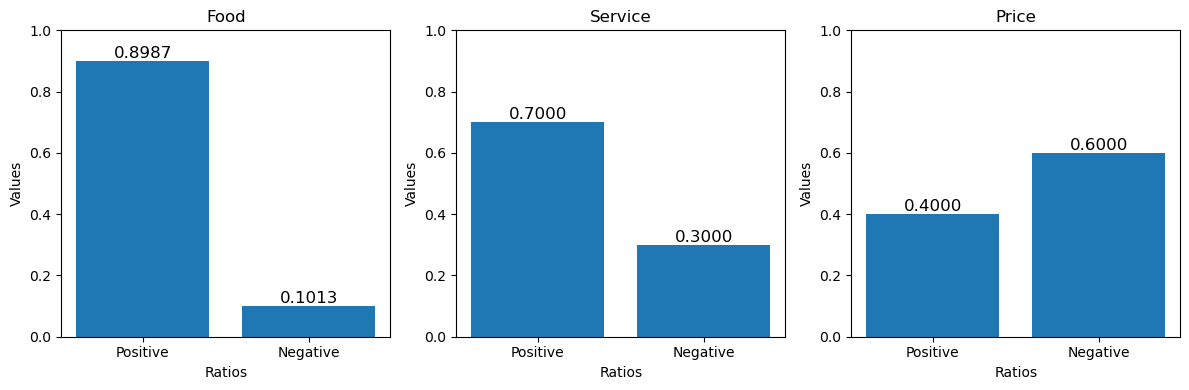

In [111]:
draw_bar_charts(foodR, serviceR, priceR)